### OpenAI gym

In [ ]:
!apt-get install -y xvfb x11-utils

In [ ]:
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
env.seed(42)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [ ]:
env.action_space

Discrete(2)

In [ ]:
def plot_enviroment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.show()
    print(img.shape)

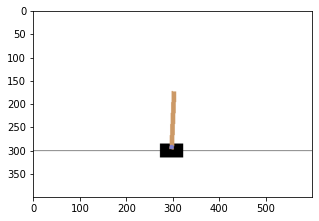

(400, 600, 3)


In [ ]:
plot_enviroment(env)

In [ ]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

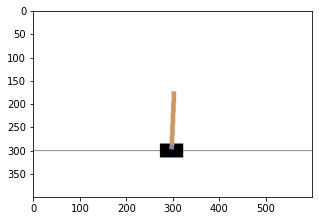

(400, 600, 3)


In [ ]:
plot_enviroment(env)

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

obs_imgs = []
total = []
for episode in range(500):
    episode_reward = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            break
    total.append(episode_reward)
    obs_imgs.append(env.render(mode="rgb_array"))

In [ ]:
np.mean(total), np.std(total), np.min(total), np.max(total)

(41.684, 8.839917646675222, 24.0, 68.0)

In [ ]:
env.seed(42)
frames = []

obs = env.reset()
for step in range(500):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch), 
        frames=len(frames), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

In [ ]:
plot_animation(frames)

### Neural Network  policies

In [56]:
n_inputs = 4

model = Sequential([
            layers.Dense(5, activation="elu", input_shape=[n_inputs]), 
            layers.Dense(1, activation="sigmoid")
])

In [68]:
obs = env.reset()
probs = model(obs[np.newaxis])
action = tf.argmax(probs, axis=1).numpy()
guess = tf.constant([[True if action[0] != i else False for i in range(4)]]).numpy()
y_target = tf.ones((1,4)) - tf.cast(guess, dtype=np.float32)
loss = tf.reduce_mean(keras.losses.categorical_crossentropy(y_target, probs))
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.0996125>

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) -2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) 
    for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std 
            for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_rewards([10, 0, -50], 0.8)

array([-22, -40, -50])

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, 
                                                    n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index] 
             for episode_index, final_rewards in enumerate(all_final_rewards) 
             for step, final_reward in enumerate(final_rewards)], 
            axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))


### Markov decision Process

In [ ]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], 
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]], 
        [None, [0.8, 0.1, 0.1], None]]
rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]], 
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]], 
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [ ]:
gamma = 0.90
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [transition_probabilities[s][a][sp] * 
                 (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) 
                 for sp in range(3)])
history1 = np.array(history1)

In [ ]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [ ]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

### Q-Learning

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [ ]:
Q_values = np.full((3, 3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state][action] = 0

alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0
history2 = []
for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1  + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
history2 = np.array(history2)

In [ ]:
np.argmax(Q_values, axis=1)

In [ ]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k-")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])


### DQN

In [ ]:
env = gym.make("CartPole-v0")
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2      # == env.action_shape.n

In [ ]:
model = keras.Sequential([
            layers.Dense(32, activation="elu", input_shape=input_shape), 
            layers.Dense(32, activation="elu"), 
            layers.Dense(n_outputs)
])

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [ ]:
from collections import deque
replay_buffer = deque(maxlen=2000)

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch]) 
            for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_value = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_value, axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(400):
    obs = env.reset()
    for step in range(200):
        episilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, episilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size)

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
plot_animation(frames)

### Deep Q-Learning Variants

#### Fixed Q-Value target

In [ ]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
# next_Q_values = target.predict(state)

In [ ]:
if episode % 50 == 0:
    target.set_weights(model.get_weights())

#### Double DQN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = Sequential([
            layers.Dense(32, activation="elu", input_shape=[4]), 
            layers.Dense(32, activation="elu"), 
            layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values  = model.predict(next_states)
    best_next_states = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_states, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:3f}".format(episode, step+1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
model.set_weights(best_weights)

Episode: 599, Steps: 182, eps: 0.010000

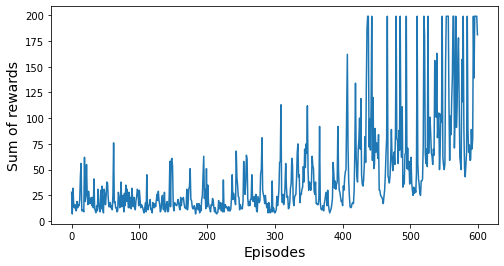

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
env.seed(44)
state = env.reset()

frames = []
for step in range(200):
    action = epsilon_greedy_policy(state)
    state, rewards, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
plot_animation(frames)

#### Dueling DQN

In [ ]:
K = keras.backend

input_states = layers.Input(shape=[4])
hidden1 = layers.Dense(32, activation="elu")(input_states)
hidden2 = layers.Dense(32, activation="elu")(hidden1)
state_values = layers.Dense(1)(hidden2)
raw_advantages = layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model([input_states], [Q_values])

### TF-Agents

#### installation

In [ ]:
!apt-get install -y xvfb x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 0s (2,627 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2

In [ ]:
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

     |████████████████████████████████| 538 kB 5.3 MB/s 
     |████████████████████████████████| 448 kB 45.3 MB/s 
  Created wheel for PyOpenGL-accelerate: filename=PyOpenGL_accelerate-3.1.5-cp37-cp37m-linux_x86_64.whl size=1599447 sha256=e7b802829e78a8291aab8249d703b605b73fce778eb2df1639f670ee50d16834
  Stored in directory: /root/.cache/pip/wheels/1c/f5/6f/169afb3f2d476c5e807f8515b3c9bc9b819c3962316aa804eb
Successfully built PyOpenGL-accelerate


In [ ]:
!pip install -U tf-agents

     |████████████████████████████████| 1.3 MB 4.6 MB/s 


In [ ]:
!pip install --upgrade gym==0.19.0

     |████████████████████████████████| 1.6 MB 4.6 MB/s 
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663118 sha256=38c8b3b9bcb9ec5fa9a9c920aa5037e7daa578beed019d2ed43752a927a7c7d0
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
!pip install -U 'gym[atari]'

     |████████████████████████████████| 2.8 MB 5.1 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [ ]:
!pip install ale-py

     |████████████████████████████████| 1.6 MB 4.6 MB/s 


In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
def plot_enviroment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.show()
    print(img.shape)

#### TF-Agent Environments

In [ ]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

/usr/local/lib/python3.7/dist-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()
/usr/local/lib/python3.7/dist-packages/gym/logger.py:34: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
env.gym

In [ ]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [ ]:
env.step(1)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})

#### Environment Specifications

In [ ]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [ ]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [ ]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

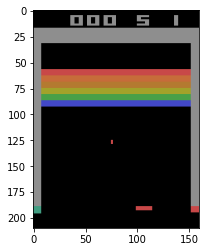

(210, 160, 3)


In [ ]:
plot_enviroment(env)

In [ ]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

#### Environment Wrapper and Atari Preprocessing

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)

In [ ]:
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4", 
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)], 
    env_wrappers=[lambda env: ActionRepeat(env, times=4)])

/usr/local/lib/python3.7/dist-packages/gym/logger.py:34: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = "BreakoutNoFrameskip-v4"
env = suite_atari.load(
    environment_name, 
    max_episode_steps=max_episode_steps, 
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:34: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
tf_env = TFPyEnvironment(env)

#### Creating the Deep Q-Network

In [ ]:
from tf_agents.networks.q_network import QNetwork

proprecessing_layer = layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]

q_net = QNetwork(
    tf_env.observation_spec(), 
    tf_env.action_spec(), 
    preprocessing_layers=proprecessing_layer, 
    conv_layer_params=conv_layer_params, 
    fc_layer_params=fc_layer_params)

#### Creating the DQN Agent

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, 
                                     epsilon=1e-5, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps=250000 // update_period, 
    end_learning_rate=0.01)
agent = DqnAgent(
    tf_env.time_step_spec(), 
    tf_env.action_spec(), 
    q_network=q_net,
    optimizer=optimizer, 
    target_update_period=2000, 
    td_errors_loss_fn=keras.losses.Huber(reduction="none"), 
    gamma=0.99, train_step_counter=train_step, 
    epsilon_greedy=lambda : epsilon_fn(train_step))
agent.initialize()

#### Creating the Replay Buffer and the Corresponding Observer

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, 
    batch_size=tf_env.batch_size, 
    max_length=100000)

In [ ]:
replay_buffer_observer = replay_buffer.add_batch

In [ ]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

#### Creating Training Metrics

In [ ]:
from tf_agents.metrics import tf_metrics

training_metrics = [
        tf_metrics.NumberOfEpisodes(), 
        tf_metrics.EnvironmentSteps(), 
        tf_metrics.AverageReturnMetric(), 
        tf_metrics.AverageEpisodeLengthMetric()
]

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging

l = logging.getLogger().setLevel(logging.INFO)
log_metrics(training_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


#### Creating the Collect Driver

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env, 
    agent.collect_policy, 
    observers=[replay_buffer_observer] + training_metrics, 
    num_steps=update_period
)

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(
    tf_env.time_step_spec(), 
    tf_env.action_spec()
)
init_driver = DynamicStepDriver(
    tf_env, 
    initial_collect_policy, 
    observers=[replay_buffer.add_batch, ShowProgress(20000)], 
    num_steps=20000)
final_time_step, final_policy_state = init_driver.run()

20000/20000

#### Creating the Dataset

In [ ]:
trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [ ]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [ ]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [ ]:
from tf_agents.trajectories.trajectory import to_transition
time_steps, action_steps, next_time_steps = to_transition(trajectories)

In [ ]:
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64, 
    num_steps=2, 
    num_parallel_calls=3
).prefetch(3)

#### Creating the Training Loop

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss: {:.5f}".format(iteration, train_loss[0]), end="")
        if iteration % 1000 == 0:
            log_metrics(training_metrics)

In [ ]:
train_agent(1000)

INFO:absl: 
		 NumberOfEpisodes = 2
		 EnvironmentSteps = 384
		 AverageReturn = 0.5
		 AverageEpisodeLength = 151.5


999 loss: 0.00003

### Exercise

In [1]:
!apt-get install -y xvfb x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (845 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1

In [2]:
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

     |████████████████████████████████| 538 kB 8.2 MB/s 
     |████████████████████████████████| 448 kB 14.2 MB/s 
  Created wheel for PyOpenGL-accelerate: filename=PyOpenGL_accelerate-3.1.5-cp37-cp37m-linux_x86_64.whl size=1599531 sha256=6c71f9b8667bfaf75ab9c9fd9da657e1baf182d113ab4f4a6ada3bd65919227f
  Stored in directory: /root/.cache/pip/wheels/1c/f5/6f/169afb3f2d476c5e807f8515b3c9bc9b819c3962316aa804eb
Successfully built PyOpenGL-accelerate


In [3]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [4]:
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [5]:
def plot_enviroment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.show()
    print(img.shape)

In [6]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch), 
        frames=len(frames), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

In [7]:
env = gym.make("LunarLander-v2")
env

<TimeLimit<LunarLander<LunarLander-v2>>>

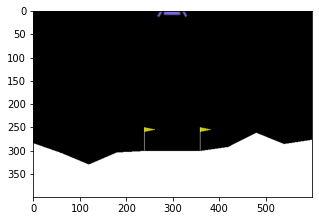

(400, 600, 3)


In [8]:
plot_enviroment(env);

In [9]:
env.reset()
obs, reward, done, info = env.step(2)
obs

array([-0.01302948,  1.4291568 , -0.65715796,  0.41936243,  0.01521563,
        0.15274179,  0.        ,  0.        ], dtype=float32)

In [50]:
n_inputs = [8]

model = Sequential([
            layers.Dense(32, activation="elu", input_shape=n_inputs), 
            layers.Dense(16, activation="elu"), 
            layers.Dense(4, activation="softmax")
])

In [51]:
def play_one_step(obs, env, model, loss_fn):
    with tf.GradientTape() as tape:
        probs = model(obs[np.newaxis])
        logits = tf.math.log(probs + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probs))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

In [52]:
def environment_frames(env, loss_fn=keras.losses.sparse_categorical_crossentropy):
    obs = env.reset()
    frames = []
    for i in range(500):
        obs, reward, done, grads = play_one_step(obs, env, model, loss_fn)
        frames.append(env.render(mode="rgb_array"))
        if done:
            break
    return frames

In [53]:
plot_animation(environment_frames(env))

In [14]:
def play_multiple_episodes(env, n_iters, max_steps, model, loss_fn=keras.losses.categorical_crossentropy):
    total_rewards = []
    total_grads = []
    for iter in range(n_iters):
        obs = env.reset()
        current_rewards = []
        current_grads = []
        for step in range(max_steps):
            obs, reward, done, grads = play_one_step(obs, env, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        total_rewards.append(current_rewards)
        total_grads.append(current_grads)
    return total_rewards, total_grads, step

In [15]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted

def discounted_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) 
    for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std 
            for discounted_rewards in all_discounted_rewards]

In [54]:
n_iterations = 200
n_episodes_per_update = 15
n_max_steps = 500
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=5e-3)
loss_fn = keras.losses.sparse_categorical_crossentropy

for iter in range(n_iterations):
    all_rewards, all_grads, step = play_multiple_episodes(env, n_episodes_per_update, 
                                                    n_max_steps, model, loss_fn)
    print("\rEpisode: {}, Step: {}".format(iter+1, step), end='')
    all_final_rewards = discounted_normalize_rewards(all_rewards, 
                                                     discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
             for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Episode: 200, Step: 499

In [23]:
plot_animation(environment_frames(env), repeat=True)